In [1]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.basemap import Basemap

import gsw
from gsw import conversions

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

In [3]:
data = sio.loadmat('../observations/MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']
struct_axis = data['ax']
struct_slope = data['cs']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype
dtype_axis = struct_axis.dtype
dtype_slope = struct_slope.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}
data_axis = {n: struct_axis[n][0, 0] for n in dtype_axis.names}
data_slope = {n: struct_slope[n][0, 0] for n in dtype_slope.names}

obs_lat_s = data_south['latx'][0,:]
obs_lon_s = data_south['lonx'][0,:]
obs_z_s = data_south['z'][:, 0]
obs_s_s = data_south['sal'][:]


obs_lat_n = data_north['latx'][0,:]
obs_lon_n = data_north['lonx'][0,:]
obs_z_n = data_north['z'][:, 0]
obs_s_n = data_north['sal'][:]

obs_lat_p = data_slope['latx'][0,:]
obs_lon_p = data_slope['lonx'][0,:]
obs_z_p = data_slope['z'][:, 0]
obs_s_p = data_slope['sal'][:]

In [4]:
def get_vels(dirname, fname, meshmaskname, time_s, time_f):
    
    files = general_functions.get_files(dirname, fname, 'grid_T')        
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(files) as ds:
        vel0 = ds.variables['vosaline'][time_s:time_f,:,y,x]
        depth = ds.variables['deptht'][:]
        nav_lat = ds.variables['nav_lat'][y, x]
        nav_lon = ds.variables['nav_lon'][y, x]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        mask0 = dsM.variables['tmask'][0,:,y,x]

    mask = np.tile(mask0, (vel0.shape[0], 1, 1, 1))

    vel = np.ma.array(vel0, mask=1 - mask)
    
    return vel, mask, depth, nav_lon, nav_lat

In [5]:
def reduce_list(any_list, number_of_values_to_combine):
    ret_list = []
    for i in range(len(any_list)//number_of_values_to_combine):
        new_value = 0
        for j in range(number_of_values_to_combine):
            new_value += any_list[i*number_of_values_to_combine + j]
        ret_list.append(new_value/number_of_values_to_combine)
    return ret_list

In [6]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_baseAW/'
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'
time_s = 24
time_f = time_s+48

vosaline, tmask, deptht, nav_lon, nav_lat = get_vels(dirname, fname, meshmaskname, time_s, time_f)
vosaline_daily = np.mean(vosaline, axis=0)
tmask_daily = np.mean(tmask, axis=0)

f_s = interpolate.interp1d(deptht, vosaline_daily, axis=0, fill_value='extrapolate')
f_m = interpolate.interp1d(deptht, tmask_daily, axis=0, fill_value='extrapolate')

mod_s = f_s(obs_z_s)
mod_mask = f_m(obs_z_s)

In [120]:
def plot_all(n_depths, mod_s, mod_mask):
    
    fs_numb, fs_str = 25, 30

    fig = plt.figure(figsize=(16, 22))
    gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,0.05])
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, :])
    axoff = plt.subplot(gs[2,:]); axoff.axis('off')
    
    for ax, n in zip([ax1, ax2], n_depths):
        
        cmap = cmapIAM
        cmap.set_bad('#8b7765')
        ax.set_xlabel('Longitude', fontsize=fs_str, labelpad=40)
        ax.set_ylabel('Latitude', fontsize=fs_str, labelpad=80)
        s = 600
        ec = 'k'
        
        m = Basemap(width=192000, height=130000, resolution='c',projection='stere',
                    lat_ts=70, lat_0=70.1, lon_0=-138.55, ax=ax)
        m.drawparallels(np.arange(-80.,81.,0.5), labels=[True,False,False,False], 
                        color='#D9CFC1', fontsize=fs_numb, zorder=4)
        m.drawmeridians(np.arange(-180.,181.,1.0), labels=[False,False,False,True], 
                        color='#D9CFC1', fontsize=fs_numb, zorder=4)
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        

        plot_mod_s = np.ma.array(mod_s[n, :, :], mask=1 - mod_mask[n, :, :])
        vmin, vmax = plot_mod_s.min(), plot_mod_s.max()

        nav_lon_new, nav_lat_new = m(nav_lon, nav_lat)
        p = ax.pcolormesh(nav_lon_new, nav_lat_new, plot_mod_s, vmin=vmin, vmax=vmax, cmap=cmap)
        
        if ax == ax2:
            cbaxes = fig.add_axes([0.2, 0.05, 0.6, 0.02])
            cbar = fig.colorbar(p, format='%1.1f', ax=ax, cax=cbaxes, orientation='horizontal')#, ticks=ticks)
            cbar.ax.tick_params(labelsize=fs_numb)
            cbar.ax.set_xlabel('Salinity [g kg$^{-1}$]', fontsize=fs_str)

        obs_lon_list = [obs_lon_n, obs_lon_s, obs_lon_p]
        obs_lat_list = [obs_lat_n, obs_lat_s, obs_lat_p]
        obs_s_list   = [  obs_s_n,   obs_s_s,   obs_s_p]
        zos = [4, 3, 2]
        labels = ['n', 's', 'p']

        for obs_lon, obs_lat, obs_s0, zo, lab in zip(obs_lon_list, obs_lat_list, obs_s_list, zos, labels):
            obs_s = conversions.SA_from_SP(obs_s0[n, :], 10, obs_lon, obs_lat)

            if lab=='n' and n<100: e=3
            elif lab=='n' and n>100: e=2
            elif lab=='s' and n<100: e=5
            elif lab=='s' and n>100: e=5
            elif lab=='p' and n<100: e=3
            elif lab=='p' and n>100: e=3
                
            obs_lon_plot0 = reduce_list(obs_lon,e)
            obs_lat_plot0 = reduce_list(obs_lat,e)
            obs_s_plot = reduce_list(obs_s,e)

            obs_lon_plot, obs_lat_plot = m(obs_lon_plot0, obs_lat_plot0)

            p=ax.scatter(obs_lon_plot[::-1], obs_lat_plot[::-1], c=obs_s_plot[::-1], 
                         s=s, edgecolors=ec, cmap=cmap, vmin=vmin, vmax=vmax, alpha=1, zorder=zo, marker='d')

        ax.set_title('Depth $\sim$ ' + str(np.round(obs_z_s[n],1))+' m' , 
                     fontsize=fs_str, pad=20)

#         not this
#         axins = inset_axes(ax,
#                         width="40%",  # width = 10% of parent_bbox width
#                         height="5%",  # height : 50%
#                         loc=1)
#         axins.xaxis.set_ticks_position("bottom")
#         cb = fig.colorbar(p, cax=axins, orientation='horizontal')
#         tick_locator = ticker.MaxNLocator(nbins=4)
#         cb.locator = tick_locator
#         cb.update_ticks()

        
    fig.tight_layout()
    plt.subplots_adjust(top=0.99, hspace=0.3)
    fig.patch.set_facecolor('white') 
    #fig.savefig('./fig_observations_salinity.png', dpi=150, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())
    #print('flow direction for hours ' + str(time_s) + '-'+ str(time_f))
    return fig

# Plots

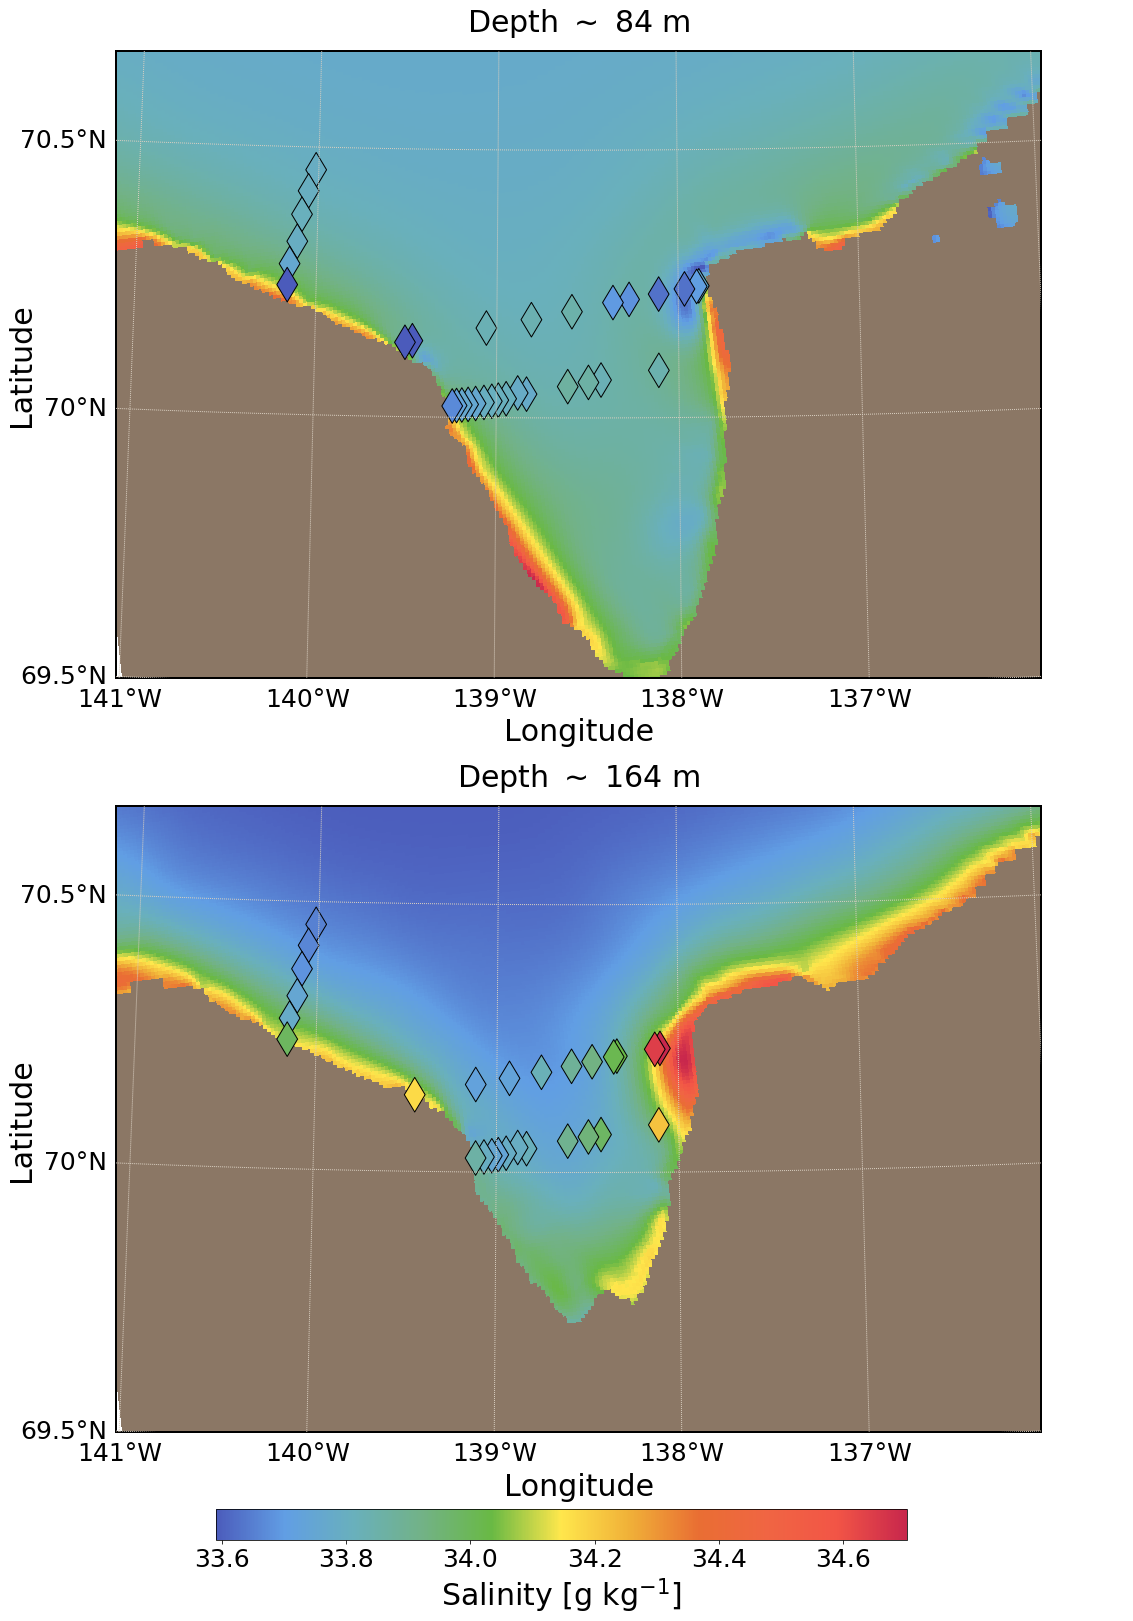

In [121]:
n_depths = [84, 164]
fig = plot_all(n_depths, mod_s, mod_mask)